In [1]:
import numpy as np
from scipy import signal

In [2]:
H_h = np.array([1, -1])/np.sqrt(2)
H_l = np.array([1, 1])/np.sqrt(2)

In [3]:
F_2 = np.arange(1,17, dtype=float)
F_2 = F_2.reshape(4,4)

In [4]:
def down_sample(array ,sample_factor):
    array = np.array(array, dtype=float)
    array = array[::sample_factor]
    if (len(array.shape) == 2):
        array = array.transpose()
        array = array[::sample_factor]
    return array

In [5]:
def convolve(array, kernel):
    array = np.array(array, dtype=float)
    res = np.convolve(np.array(array),np.array(kernel), mode='full')
    res = res[len(kernel) - 1::]
    return res

In [6]:
def fried_model_gradient(image):
    X = np.array(image, dtype=float)
    Y = np.array(image, dtype=float)
    H_h = np.array([1,-1])
    H_l = np.array([1, 1])
    for i in range(len(image)):
        X[i,:] = convolve(X[i,:],H_h)
        Y[:,i] = convolve(Y[:,i],H_h)
    for i in range(len(image)):
        X[:,i] = convolve(X[:,i],H_l)
        Y[i,:] = convolve(Y[i,:],H_l)
    return X * 0.5, Y * 0.5

In [7]:
from scipy.signal import convolve2d as conv2d
def convolve_2d(array_2d, kernel, mode):
    res = np.array(array_2d, dtype=float)
    kernel = np.array(kernel)
    if (mode == 'horizontal'):
        res = conv2d(res, kernel[None, :])
        res = res[:,len(kernel)-1:]
    if (mode == 'vertical'):
        res = conv2d(res, kernel[:, None])
        res = res[len(kernel)-1:,:]
    return res

# Простая матрица LL квадрант


In [8]:
X_2, Y_2 = fried_model_gradient(F_2)
F_2_hl = down_sample(X_2,2)
F_2_lh = down_sample(Y_2,2)
F_2_lh

array([[ 4.,  4.],
       [ 4.,  4.]])

In [9]:
tmp1 = convolve_2d(X_2, H_l, mode='horizontal')
tmp2 = convolve_2d(tmp1, H_l, mode='horizontal')
X_1 = down_sample(np.sqrt(2) * convolve_2d(tmp2, np.array([1,0,1])/np.sqrt(2), mode='vertical'), 2)
F_0_hl = down_sample(X_1, 2)
F_0_hl

array([[ 4.]])

In [10]:
tmp1 = convolve_2d(Y_2, np.array([1,0,1])/np.sqrt(2), mode = 'horizontal')
tmp2 = convolve_2d(tmp1, H_l, mode = 'vertical')
Y_1 = np.sqrt(2) * down_sample(convolve_2d(tmp2, H_l, mode = 'vertical'), 2)
F_0_lh = down_sample(Y_1, 2)
F_0_lh

array([[ 16.]])

In [11]:
tmp1 = convolve_2d(Y_2, np.array([1,0,-1])/np.sqrt(2), mode = 'horizontal')
tmp2 = convolve_2d(tmp1, H_l, mode = 'vertical')
tmp3 = convolve_2d(tmp2, H_l, mode = 'vertical')
F_0_hh = np.sqrt(2) * down_sample(tmp3, 4)

In [331]:
F_0_ll = np.array([[np.mean(F_2)]])
F_0_ll = F_0_ll * 4

In [189]:
tmp1 = convolve_2d(X_2, H_l, mode = 'horizontal')
tmp2 = convolve_2d(tmp1, H_l, mode = 'horizontal')
tmp3 = convolve_2d(tmp2, np.array([1,0,-1])/np.sqrt(2), mode = 'vertical')
F_0_hh = np.sqrt(2) * down_sample(tmp3, 4)

In [385]:
import pywt
coeffs = pywt.dwt2(F_2, 'haar')
cA, (cH, cV, cD) = coeffs
coeffs = pywt.dwt2(cA, 'haar')
coeffs
coeffs[1]

(array([[-16.]]), array([[-4.]]), array([[ 0.]]))

In [15]:
my_coefs = np.array([F_0_ll, (-F_0_lh,-F_0_hl, -F_0_hh)])
tmp1 = pywt.idwt2(my_coefs,'haar')
im = pywt.idwt2([tmp1, (-F_2_lh, -F_2_hl, np.array([[0,0],[0,0]]))], 'haar')
im

array([[  1.,   2.,   3.,   4.],
       [  5.,   6.,   7.,   8.],
       [  9.,  10.,  11.,  12.],
       [ 13.,  14.,  15.,  16.]])

# HH квадрант

In [38]:
tmp1 = convolve_2d(X_2, np.array([1, 0, 1]) / np.sqrt(2), mode = 'horizontal')
tmp2 = convolve_2d(tmp1, H_h, mode = 'vertical')
tmp3 = convolve_2d(tmp2, H_h, mode = 'vertical')
X_hh_2 = np.sqrt(2) * down_sample(tmp3, 2)

array([[ 0.,  0.],
       [ 0.,  0.]])

In [41]:
tmp1 = convolve_2d(X_2, H_h, mode = 'horizontal')
tmp2 = convolve_2d(tmp1, H_h, mode = 'horizontal')
tmp3 = convolve_2d(tmp2, np.array([1, 0, -1]) / np.sqrt(2), mode = 'vertical')
Y_hh_2 = np.sqrt(2) * down_sample(tmp3, 2)

In [40]:
F_H_lh_0 = down_sample(X_hh_2, 2)

array([[ 0.]])

In [42]:
F_H_hl_0 = down_sample(Y_hh_2, 2)

array([[ 0.]])

In [37]:
tmp1 = convolve_2d(X_2, np.array([1, 0, -1]) / np.sqrt(2), mode = 'horizontal')
tmp2 = convolve_2d(tmp1, H_h, mode = 'vertical')
tmp3 = convolve_2d(tmp2, H_h, mode = 'vertical')
F_H_hh_0 = np.sqrt(2) * down_sample(tmp3, 4)

array([[ 0.]])

In [43]:
im = pywt.idwt2([np.array([[0.]]), (-F_H_lh_0, -F_H_hl_0, -F_H_hh_0)], 'haar')
im

array([[ 0.,  0.],
       [ 0.,  0.]])

# Реализация общей функции влоб

In [409]:
def get_image_from_gradient(grad_X, grad_Y, mean = np.array([[1.]]), ll_right = np.array([[0.]])):
    M = int(np.log2(len(grad_X)))
    HL_left = dict()
    LH_left = dict()
    HH_left = dict()
    LL_left = np.array([[mean]])
    X_left = dict({M : grad_X})
    Y_left = dict({M : grad_Y})
    HL_left[M - 1] = down_sample(X_left[M], 2)
    LH_left[M - 1] = down_sample(Y_left[M], 2)
    
    X_right = dict({M : grad_X})
    Y_right = dict({M : grad_Y})
    HL_right = dict()
    LH_right = dict()
    HH_right = dict()
    LL_right = ll_right
    
    for k in range(2, M + 1)[::-1]:
        #Left
        #X^k
        tmp1 = convolve_2d(X_left[k], H_l, mode='horizontal')
        tmp2 = convolve_2d(tmp1, H_l, mode='horizontal')
        X_left[k - 1] = down_sample(np.sqrt(2) * convolve_2d(tmp2, np.array([1,0,1]) / np.sqrt(2), mode='vertical'), 2)
        #Y^k
        tmp1 = convolve_2d(Y_left[k], np.array([1,0,1]) / np.sqrt(2), mode = 'horizontal')
        tmp2 = convolve_2d(tmp1, H_l, mode = 'vertical')
        Y_left[k - 1] = np.sqrt(2) * down_sample(convolve_2d(tmp2, H_l, mode = 'vertical'), 2)
        #LH^k-2, HL^k-2
        LH_left[k - 2] = down_sample(Y_left[k - 1], 2)
        HL_left[k - 2] = down_sample(X_left[k - 1], 2)
        #HH^k-2
        tmp1 = convolve_2d(X_left[k], H_l, mode = 'horizontal')
        tmp2 = convolve_2d(tmp1, H_l, mode = 'horizontal')
        tmp3 = convolve_2d(tmp2, np.array([1,0,-1]) / np.sqrt(2), mode = 'vertical')
        HH_left[k - 2] = np.sqrt(2) * down_sample(tmp3, 4)
        #Right
        #X_right
        if (k == M):
            tmp1 = convolve_2d(X_right[k], np.array([1, 0, 1]) / np.sqrt(2), mode = 'horizontal')
            tmp2 = convolve_2d(tmp1, H_h, mode = 'vertical')
            tmp3 = convolve_2d(tmp2, H_h, mode = 'vertical')
            X_right[k - 1] = np.sqrt(2) * down_sample(tmp3, 2)
        else:
            tmp1 = convolve_2d(X_right[k], np.array([1, 0, 1]) / np.sqrt(2), mode = 'horizontal')
            tmp2 = convolve_2d(tmp1, H_l, mode = 'vertical')
            tmp3 = convolve_2d(tmp2, H_l, mode = 'vertical')
            X_right[k - 1] = np.sqrt(2) * down_sample(tmp3, 2)
        #Y_right
        if (k == M):
            tmp1 = convolve_2d(Y_right[k], H_h, mode = 'horizontal')
            tmp2 = convolve_2d(tmp1, H_h, mode = 'horizontal')
            tmp3 = convolve_2d(tmp2, np.array([1, 0, -1]) / np.sqrt(2), mode = 'vertical')
            Y_right[k - 1] = np.sqrt(2) * down_sample(tmp3, 2)
        else:
            tmp1 = convolve_2d(Y_right[k], H_h, mode = 'horizontal')
            tmp2 = convolve_2d(tmp1, H_h, mode = 'horizontal')
            tmp3 = convolve_2d(tmp2, np.array([1, 0, 1]) / np.sqrt(2), mode = 'vertical')
            Y_right[k - 1] = np.sqrt(2) * down_sample(tmp3, 2)
        #LH_right
        LH_right[k - 2] = down_sample(X_right[k - 1], 2)
        #HL_right
        HL_right[k - 2] = down_sample(Y_right[k - 1], 2)
        #HH
        if (k == M):
            tmp1 = convolve_2d(X_right[k], np.array([1, 0, -1]) / np.sqrt(2), mode = 'horizontal')
            tmp2 = convolve_2d(tmp1, H_h, mode = 'vertical')
            tmp3 = convolve_2d(tmp2, H_h, mode = 'vertical')
            HH_right[k - 2] = np.sqrt(2) * down_sample(tmp3, 4)
        else:
            tmp1 = convolve_2d(X_right[k], np.array([1, 0, -1]) / np.sqrt(2), mode = 'horizontal')
            tmp2 = convolve_2d(tmp1, H_l, mode = 'vertical')
            tmp3 = convolve_2d(tmp2, H_l, mode = 'vertical')
            HH_right[k - 2] = np.sqrt(2) * down_sample(tmp3, 4)
    LL_right = ll_right
    LL_left = mean
    for k in range(M - 1):
        LL_right = pywt.idwt2([LL_right, (-LH_right[k], -HL_right[k], -HH_right[k])], 'haar')
        LL_left = pywt.idwt2([LL_left, (-LH_left[k], -HL_left[k], -HH_left[k])], 'haar')
    im = pywt.idwt2([LL_left, (-LH_left[M - 1], -HL_left[M - 1], -LL_right)], 'haar')
    return im

# Простая матрица

In [432]:
get_image_from_gradient(X_2, Y_2, mean=F_0_ll)

array([[  1.,   2.,   3.,   4.],
       [  5.,   6.,   7.,   8.],
       [  9.,  10.,  11.,  12.],
       [ 13.,  14.,  15.,  16.]])

# Изображение

In [439]:
import scipy.misc
%matplotlib inline
import matplotlib.pyplot as plt
image = scipy.misc.imread("image.jpg",mode='L')
print(image)

[[ 5  5  5 ...,  7  7  7]
 [ 3  4  4 ...,  7  7  7]
 [ 3  3  3 ...,  7  7  7]
 ..., 
 [ 2  2  2 ...,  9  9  9]
 [ 2  2  2 ..., 10 10 10]
 [ 2  2  2 ..., 10 10 10]]


In [440]:
X, Y = fried_model_gradient(image)

In [441]:
res  = get_image_from_gradient(X, Y, mean = np.array([[100000.0]])) / 255
print(mean_squared_error(image, res))

2617.06195499


# Исходное и восстановленное

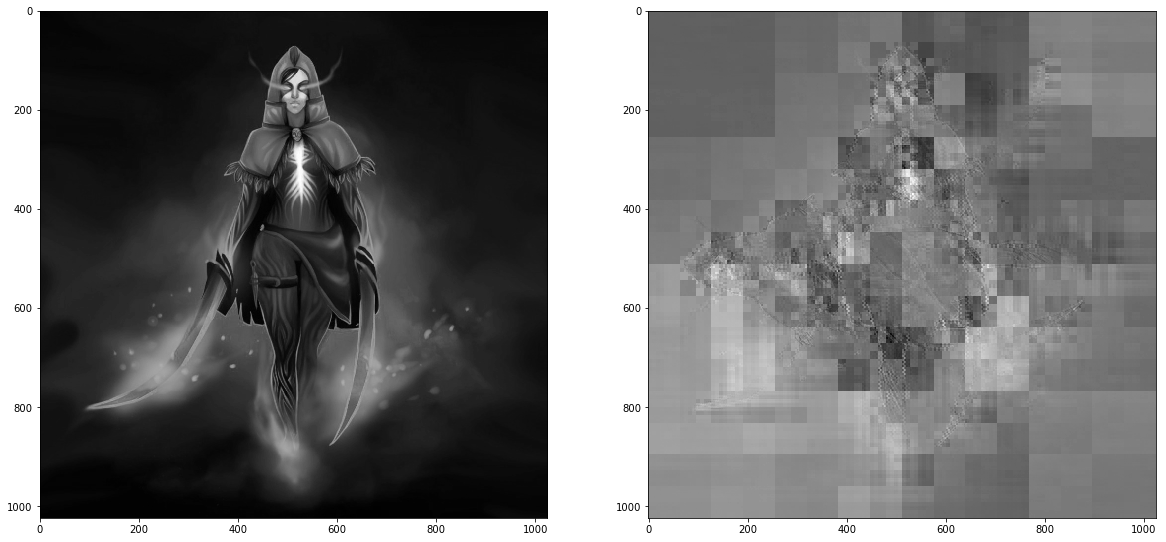

In [431]:
f, axarr = plt.subplots(1,2,figsize=(20,20))
axarr[0].imshow(image, cmap="gray")
axarr[1].imshow(res, cmap="gray")

19880.0882826


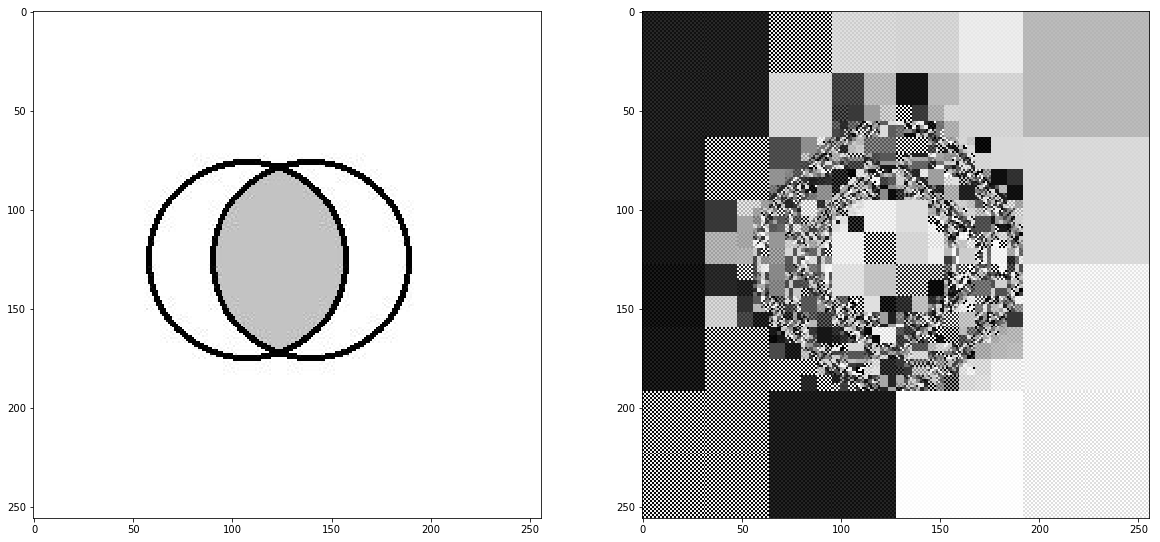

In [438]:
image = scipy.misc.imread("206-0.png",mode='L')
mean = np.array([[2**8 * np.mean(image)]])
X, Y = fried_model_gradient(image)
res  = get_image_from_gradient(X, Y, mean) % image.max()
f, axarr = plt.subplots(1,2,figsize=(20,20))
axarr[0].imshow(image, cmap="gray")
axarr[1].imshow(res, cmap="gray")
from sklearn.metrics import mean_squared_error
print(mean_squared_error(image, res))

In [437]:
import random
exmpl = np.array([10 * random.random() for i in range(64)])
exmpl = exmpl.reshape(8,8)
X, Y = fried_model_gradient(exmpl)
res  = get_image_from_gradient(X, Y, np.array([[8 * np.mean(exmpl)]]))
from sklearn.metrics import mean_squared_error
print(mean_squared_error(exmpl, res))

18.4276584164
